## Rover Project Test Notebook
This notebook contains the functions that provide the scaffolding needed to test out mapping methods.  The following steps are taken to test functions and calibrate data for the project:

* The simulator is run in "Training Mode" and some data is recorded. Note: the simulator may crash if a large (longer than a few minutes) dataset is recorded; only a small data sample is required i.e. just some example images to work with.   
* The functions are tested with the data.
* Functions are written and modified to report and map out detections of obstacles and rock samples (yellow rocks).
* `process_image()` function is populated with the appropriate steps/functions to go from a raw image to a worldmap.
* Once it is confirmed that mapping is working, `perception.py` and `decision.py` are modified to allow the rover to navigate and map in autonomous mode!

*Note: If, at any point, display windows freeze up or other confounding issues are encountered, Kernel should be restarted and output cleared from the "Kernel" menu above.*

*Uncomment and run the next cell to get code highlighting in the markdown cells.*

In [18]:
#%%HTML
#<style> code {background-color : orange !important;} </style>

In [3]:
%matplotlib inline
#%matplotlib qt # Choose %matplotlib qt to plot to an interactive window

import cv2  # OpenCV for perspective transform
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import scipy.misc  # For saving images as needed
import glob  # For reading in a list of images from a folder
import imageio
imageio.plugins


<module 'imageio.plugins' from '/home/ahmed_b7r/.local/lib/python3.10/site-packages/imageio/plugins/__init__.py'>

## Quick Look at the Data
Data can be found in the test_dataset folders. Additional data can be recorded to sample various scenarios in the simulator to hone perception methods more precisely.

Next, read in and display a random image from the test_dataset folder:

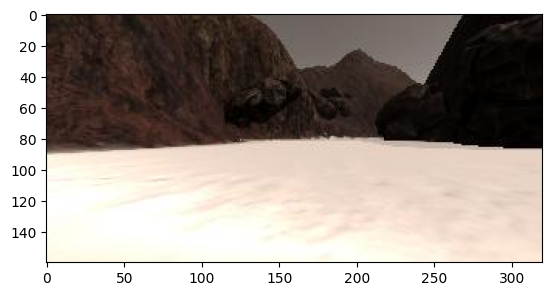

In [4]:
path = '../test_dataset/IMG/*'
img_list = glob.glob(path)

# Grab a random image and display it
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
plt.imshow(image)

## Calibration Data
Read in and display example grid and rock sample calibration images. The grid is used for perspective transform and the rock image for creating a new color selection that identifies these samples of interest.

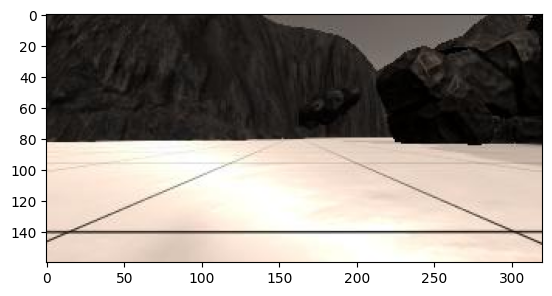

In [5]:
# In the simulator the grid on the ground can be toggled on for calibration.
example_grid = '../calibration_images/example_grid1.jpg'
grid_img = mpimg.imread(example_grid)
plt.imshow(grid_img)
#plt.savefig('grid_img.png')

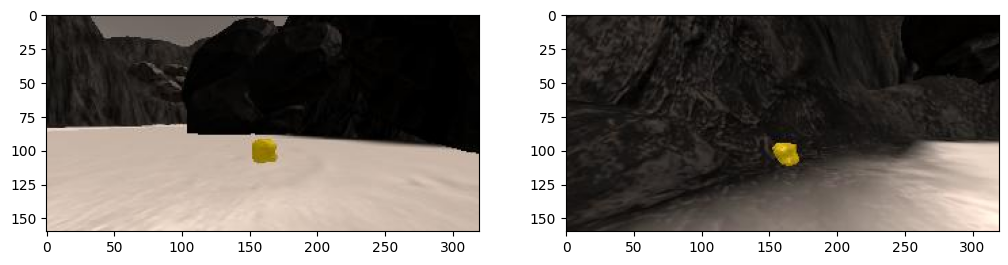

In [6]:
# The rock samples can be toggled on with the 0 (zero) key.
example_rock = '../calibration_images/example_rock1.jpg'
example_rock2 = '../calibration_images/example_rock2.jpg'
rock_img = mpimg.imread(example_rock)
rock_img2 = mpimg.imread(example_rock2)

fig = plt.figure(figsize=(19,7))
plt.subplot(131)
plt.imshow(rock_img)
plt.subplot(132)
plt.imshow(rock_img2)

## Perspective Transform

Define the perspective transform function and test it on an image. 

Four source points are selected which represent a 1 square meter grid in the image viewed from the rover's front camera. These source points are subsequently mapped to four corresponding grid cell points in our "warped" image such that a grid cell in it is 10x10 pixels viewed from top-down. Thus, the front_cam image is said to be warped into a top-down view image by the perspective transformation. The example grid image above is used to choose source points for the grid cell which is in front of the rover (each grid cell is 1 square meter in the sim). The source and destination points are defined to warp the image to a grid where each 10x10 pixel square represents 1 square meter.

The following steps are used to warp an image using a perspective transform:

1. Define 4 source points, in this case, the 4 corners of a grid cell in the front camera image above.
2. Define 4 destination points (must be listed in the same order as source points!).
3. Use cv2.getPerspectiveTransform() to get M, the transform matrix.
4. Use cv2.warpPerspective() to apply M and warp front camera image to a top-down view.

Refer to the following documentation for geometric transformations in OpenCV:
http://docs.opencv.org/trunk/da/d6e/tutorial_py_geometric_transformations.html

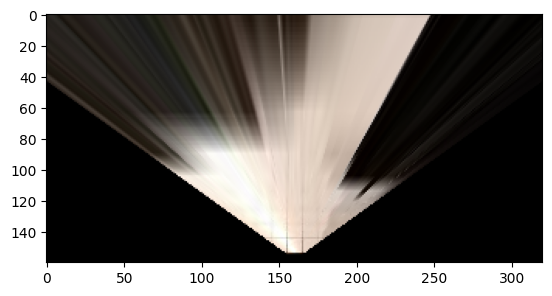

In [7]:
def perspect_transform(src_img, dst_grid=10, bottom_offset=6):
    """
    Apply a perspective transformation to input 3D image.

    Keyword arguments:
    src_img -- 3D numpy image on which perspective transform is applied
    dst_grid -- size of 2D output image box of 10x10 pixels equaling 1 Sq m
    bottom_offset -- bottom of cam image is some distance in front of rover

    Return value:
    dst_img -- 2D warped numpy image with overhead view

    """
    # Dimension of source image from rover camera
    height, width = src_img.shape[0], src_img.shape[1]

    # Numpy array of four source points defining a grid on input 3D image
    # acquired from calibration data in test notebook
    src_x1, src_y1 = 14, 140
    src_x2, src_y2 = 301, 140
    src_x3, src_y3 = 200, 96
    src_x4, src_y4 = 118, 96

    # Corresponding destination points on output 2D overhead image
    dst_x1, dst_y1 = (width/2 - dst_grid/2), (height-bottom_offset)
    dst_x2, dst_y2 = (width/2 + dst_grid/2), (height-bottom_offset)
    dst_x3, dst_y3 = (width/2 + dst_grid/2), (height-dst_grid-bottom_offset)
    dst_x4, dst_y4 = (width/2 - dst_grid/2), (height-dst_grid-bottom_offset)

    src_points_3d = np.float32([[src_x1, src_y1],
                                [src_x2, src_y2],
                                [src_x3, src_y3],
                                [src_x4, src_y4]])

    dst_points_2d = np.float32([[dst_x1, dst_y1],
                                [dst_x2, dst_y2],
                                [dst_x3, dst_y3],
                                [dst_x4, dst_y4]])

    transform_matrix = cv2.getPerspectiveTransform(src_points_3d,
                                                   dst_points_2d)
    # Keep same size as source image
    dst_img = cv2.warpPerspective(src_img, transform_matrix, (width, height))

    return dst_img

warped = perspect_transform(grid_img)
plt.imshow(warped)
#scipy.misc.imsave('../output/warped_example.jpg', warped)


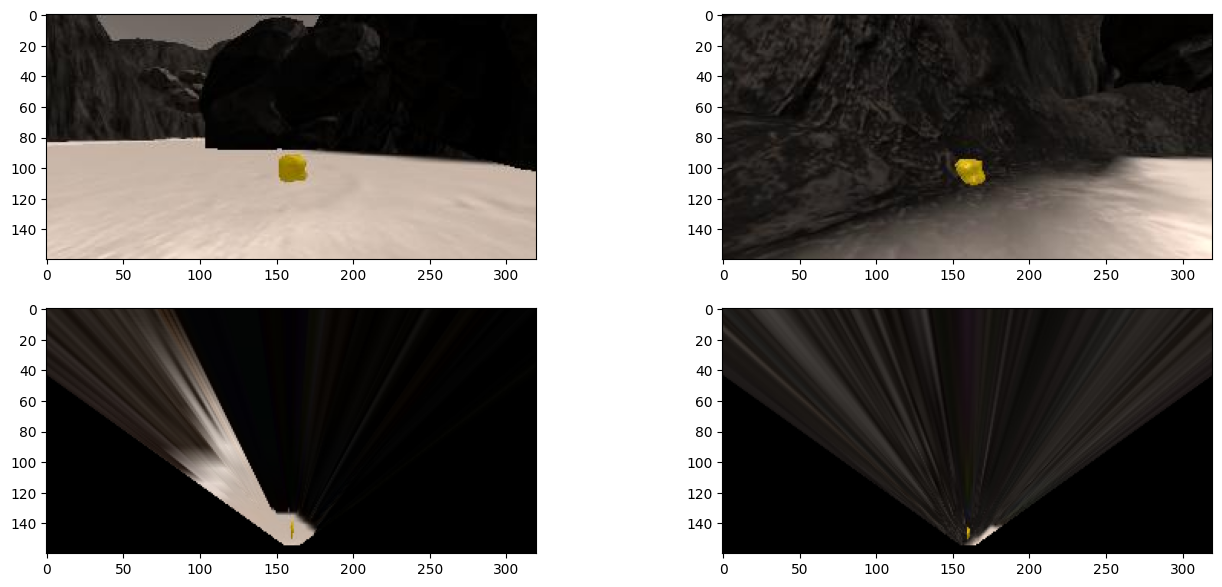

In [8]:
warped_rock = perspect_transform(rock_img)
warped_rock2 = perspect_transform(rock_img2)

fig = plt.figure(figsize=(16,7))

plt.subplot(221)
plt.imshow(rock_img)

plt.subplot(222)
plt.imshow(rock_img2)

plt.subplot(223)
plt.imshow(warped_rock)

plt.subplot(224)
plt.imshow(warped_rock2)

## Color Thresholding
Define the color thresholding function for navigable terrain and apply it to the warped image.

Ultimately, the map not only includes navigable terrain but also obstacles and the positions of the rock samples we're searching for. New functions are needed to return the pixel locations of obstacles (areas below the threshold) and rock samples (yellow rocks in calibration images), such that these areas can be mapped into world coordinates as well. 

Changing colorspaces in OpenCV: [color selection](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_colorspaces/py_colorspaces.html)

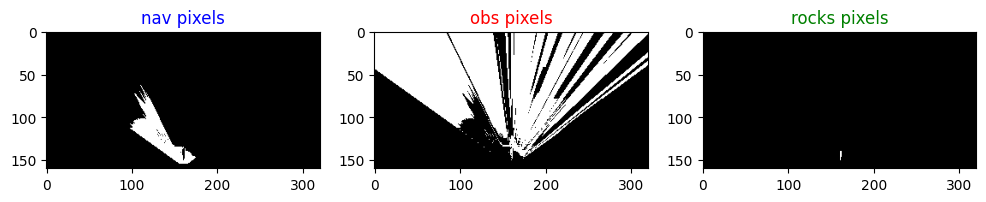

In [9]:
def color_thresh(input_img, rgb_thresh=(160, 160, 160),
                 low_bound=(75, 130, 130), upp_bound=(255, 255, 255)):
    """
    Apply color thresholds to input image for extracting ROIs.

    Keyword arguments:
    input_img -- numpy image on which RGB threshold is applied
    rgb_thresh -- RGB thresh tuple above which only ground pixels are detected
    low_bound -- HSV lower bound tuple for color range of gold rock smaples
    upp_bound -- HSV upper bound tuple for color range of gold rock smaples

    Return values:
    nav_img -- binary image identifying ground/navigable terrain pixels
    obs_img -- binary image identifying rocks/obstacle terrain pixels
    rock_img -- binary image identifying rock sample terrain pixels

    """
    # Create arrays of zeros same xy size as input_img, but single channel
    # nav ==> navigable terrain (ground)
    # obs ==> ostacles (rocks or mountains)
    nav_img = np.zeros_like(input_img[:, :, 0])
    obs_img = np.zeros_like(input_img[:, :, 0])

    # Convert BGR input_img to HSV for rock samples
    hsv_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2HSV)

    # Require that each of the R(0), G(1), B(2) pixels be above all three
    # rgb_thresh values such that pix_above_thresh will now contain a
    # boolean array with "True" where threshold was met
    pix_above_thresh = (
        (input_img[:, :, 0] > rgb_thresh[0]) &
        (input_img[:, :, 1] > rgb_thresh[1]) &
        (input_img[:, :, 2] > rgb_thresh[2])
    )
    pix_nonzero = (
        (input_img[:, :, 0] > 0) &
        (input_img[:, :, 1] > 0) &
        (input_img[:, :, 2] > 0)
    )
    # obstacle pixels are those non-zero pixels where rgb_thresh was not met
    obs_pix = np.logical_and(pix_nonzero, np.logical_not(pix_above_thresh))

    # Index the array of zeros with the boolean array and set to 1
    # those pixels where ROI threshold was met
    nav_img[pix_above_thresh] = 1
    obs_img[obs_pix] = 1

    # Threshold the HSV image to get only colors for gold rock samples
    rock_img = cv2.inRange(hsv_img, low_bound, upp_bound)

    # Return the binary image
    return nav_img, obs_img, rock_img


threshed_nav, threshed_obs, threshed_rocks = color_thresh(warped_rock)

fig = plt.figure(figsize=(12,3))
plt.subplot(131)
plt.title('nav pixels', color='blue')
plt.imshow(threshed_nav, cmap='gray')
plt.subplot(132)
plt.title('obs pixels', color='red')
plt.imshow(threshed_obs, cmap='gray')
plt.subplot(133)
plt.title('rocks pixels', color='green')
plt.imshow(threshed_rocks, cmap='gray')
#plt.savefig('color_thresh_output.png')

#scipy.misc.imsave('../output/warped_threshed.jpg', threshed*255)

##### Do some more color thresholding tests with rock sample to ensure accurate identification

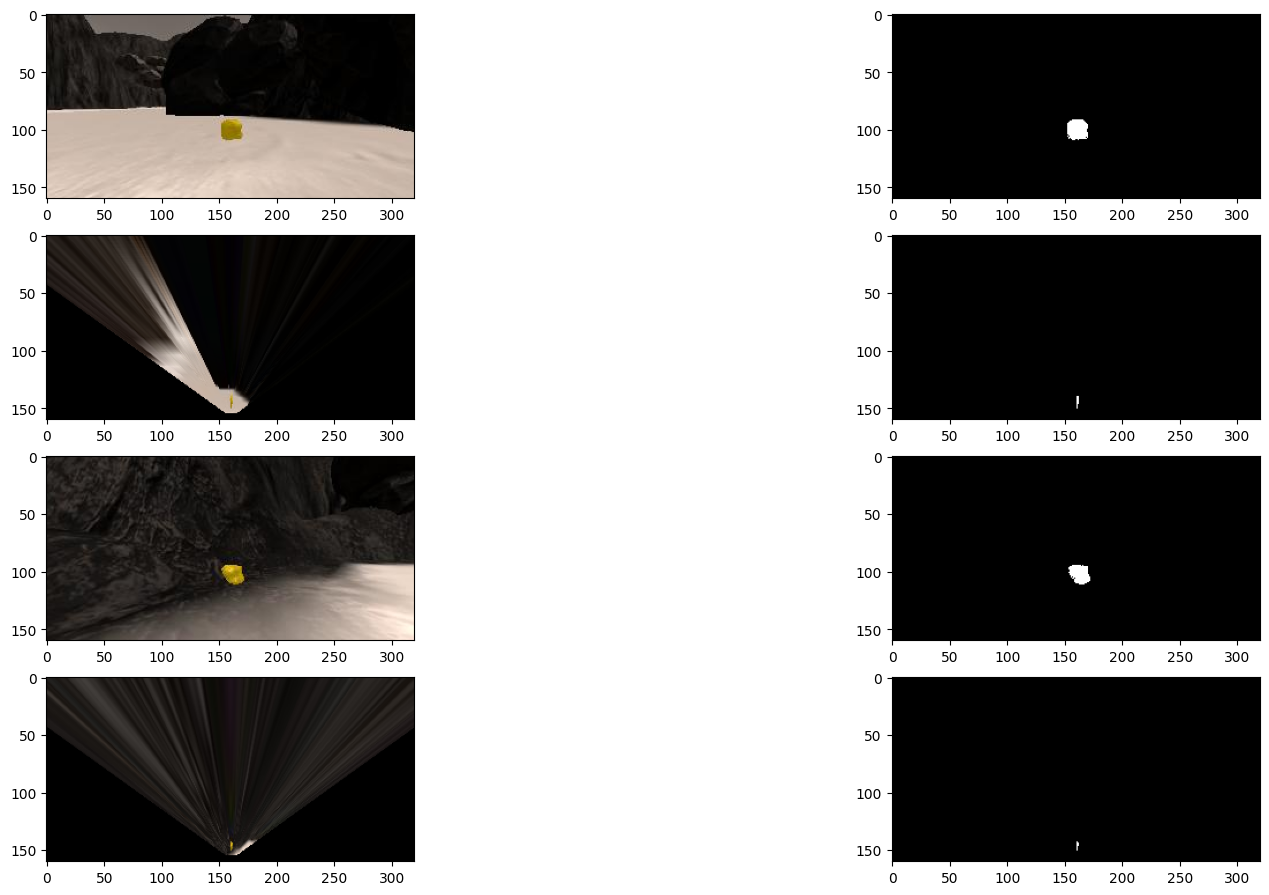

In [10]:
# apply rock color threshold to original rocks 1 and 2 images
threshed_rock_image = color_thresh(rock_img)[2]
threshed_rock2_image = color_thresh(rock_img2)[2]

# apply rock color threshold to warped rocks 1 and 2 images
threshed_warped_rock_image = color_thresh(warped_rock)[2]
threshed_warped_rock2_image = color_thresh(warped_rock2)[2]

# verify correctness of gold rock threshold
fig = plt.figure(figsize=(20,11))

plt.subplot(421)
plt.imshow(rock_img)

plt.subplot(422)
plt.imshow(threshed_rock_image, cmap='gray')

plt.subplot(423)
plt.imshow(warped_rock)

plt.subplot(424)
plt.imshow(threshed_warped_rock_image, cmap='gray')

plt.subplot(425)
plt.imshow(rock_img2)

plt.subplot(426)
plt.imshow(threshed_rock2_image, cmap='gray')

plt.subplot(427)
plt.imshow(warped_rock2)

plt.subplot(428)
plt.imshow(threshed_warped_rock2_image, cmap='gray')

## Coordinate Transformations
Define the functions used to do coordinate transforms and apply them to an image.

/tmp/ipykernel_6267/1826307090.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xpix_pts_rf = -(ypix_pts_pf - height).astype(np.float)
/tmp/ipykernel_6267/1826307090.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ypix_pts_rf = -(xpix_pts_pf - width/2).astype(np.float)


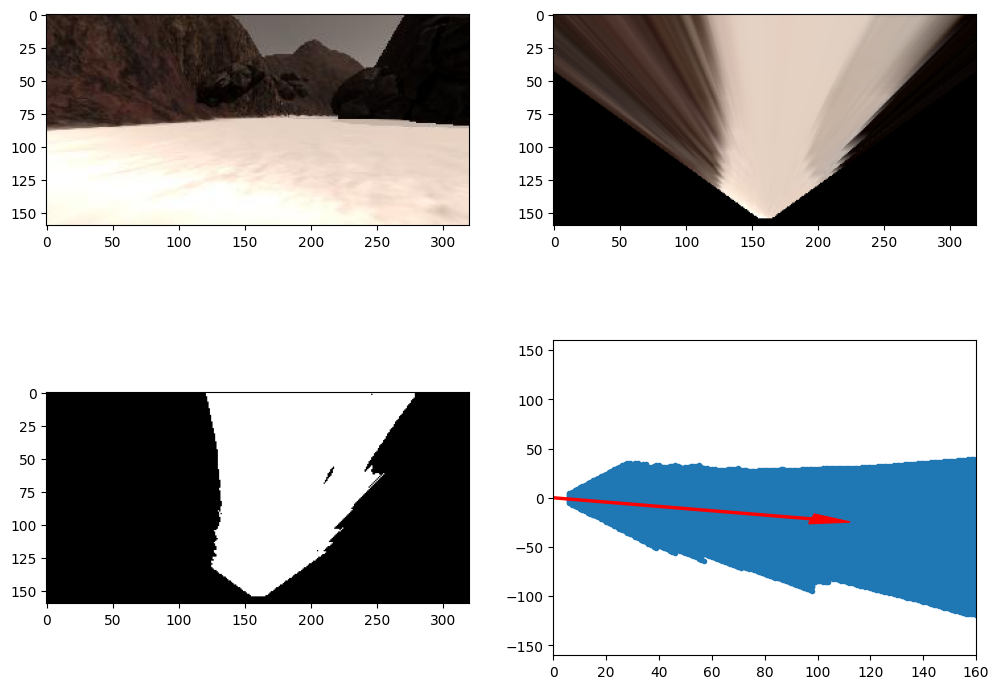

In [27]:
def perspect_to_rover(binary_img):
    """
    Transform pixel points from perspective frame to rover frame.

    Keyword arguments:
    binary_img -- single channel 2D warped numpy image in perspective frame

    Return value:
    xpix_pts_rf, ypix_pts_rf -- tuple of numpy arrays of pixel x,y points in rover frame

    """
    # Dimension of input image
    height, width = binary_img.shape[0], binary_img.shape[1]

    # Identify all nonzero pixel coords in the binary image
    ypix_pts_pf, xpix_pts_pf = binary_img.nonzero()

    # Calculate pixel positions with reference to rover's coordinate
    # frame given that rover front camera itself is at center bottom
    # of the photographed image
    xpix_pts_rf = -(ypix_pts_pf - height).astype(np.float)
    ypix_pts_rf = -(xpix_pts_pf - width/2).astype(np.float)

    return xpix_pts_rf, ypix_pts_rf

# we need polar cordinates to represnt Yaw angle & distance 
def to_polar_coords(xpix_pts, ypix_pts):
    """Convert cartesian coordinates of pixels to polar coordinates."""
    rad2deg = 180./np.pi

    dists = np.sqrt(xpix_pts**2 + ypix_pts**2)
    angles = np.arctan2(ypix_pts, xpix_pts)

    return dists, angles


def rotate_pixpts(xpix_pts, ypix_pts, angle):
    """Geometrically rotate pixel points by specified angle. ==> transfoming for Geometric domain"""
    deg2rad = np.pi/180.
    angle_rad = angle*deg2rad
    # transfoming to Geometric domain
    xpix_pts_rotated = xpix_pts*np.cos(angle_rad) - ypix_pts*np.sin(angle_rad)
    ypix_pts_rotated = xpix_pts*np.sin(angle_rad) + ypix_pts*np.cos(angle_rad)

    return xpix_pts_rotated, ypix_pts_rotated


def translate_pixpts(xpix_pts_rot, ypix_pts_rot, translation, scale_factor=10):
    """Geometrically translate rotated pixel points by rover position."""
    translation_x, translation_y = translation

    xpix_pts_translated = xpix_pts_rot/scale_factor + translation_x
    ypix_pts_translated = ypix_pts_rot/scale_factor + translation_y

    return xpix_pts_translated, ypix_pts_translated


def rover_to_world(xpix_pts, ypix_pts, rover_pos, rover_yaw, world_size=200):
    """
    Transform pixel points of ROIs from rover frame to world frame.

    Keyword arguments:
    pixpts_rf -- tuple of numpy arrays of x,y pixel points in rover frame
    rover_pos -- tuple of rover x,y position in world frame
    rover_yaw -- rover yaw angle in world frame
    world_size -- integer length of square world map of 200 x 200 pixels

    """
    # Apply rotation and translation
    xpix_pts_rot, ypix_pts_rot = rotate_pixpts(xpix_pts, ypix_pts, rover_yaw)
    xpix_pts_tran, ypix_pts_tran = translate_pixpts(xpix_pts_rot, ypix_pts_rot, rover_pos)

    # Clip pixels to be within world size
    xpix_pts_wf = np.clip(np.int_(xpix_pts_tran), 0, world_size-1)
    ypix_pts_wf = np.clip(np.int_(ypix_pts_tran), 0, world_size-1)

    return xpix_pts_wf, ypix_pts_wf


# Grab another random image
idx = np.random.randint(0, len(img_list)-1)
image = mpimg.imread(img_list[idx])
warped = perspect_transform(image)
threshed = color_thresh(warped)[0]

# Calculate pixel values in rover-centric coords and distance/angle to all pixels
xpix, ypix = perspect_to_rover(threshed)
dist, angles = to_polar_coords(xpix, ypix)
mean_dir = np.mean(angles)

# Do some plotting
fig = plt.figure(figsize=(12,9))

plt.subplot(221)
plt.imshow(image)

plt.subplot(222)
plt.imshow(warped)

plt.subplot(223)
plt.imshow(threshed, cmap='gray')

plt.subplot(224)
plt.plot(xpix, ypix, '.')

plt.ylim(-160, 160)
plt.xlim(0, 160)

arrow_length = 100
x_arrow = arrow_length * np.cos(mean_dir)
y_arrow = arrow_length * np.sin(mean_dir)

plt.arrow(0, 0, x_arrow, y_arrow, color='red', zorder=2, head_width=10, width=2)


### Separate nav angles into left and right

nav_test_angles:
[ 0.23908772  0.2331798   0.22725526 ... -0.46364761 -0.5880026
 -0.69473828]
amount:  15958
mean: -12.37335300048951

nav_test_left_angles:
[0.23908772 0.2331798  0.22725526 ... 0.46364761 0.32175055 0.16514868]
amount:  4626
mean: 13.357889178208243

nav_test_right_angles:
[-0.00624992 -0.01249935 -0.0187478  ... -0.46364761 -0.5880026
 -0.69473828]
amount:  11177
mean: -23.194735843267686



/tmp/ipykernel_6267/1826307090.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xpix_pts_rf = -(ypix_pts_pf - height).astype(np.float)
/tmp/ipykernel_6267/1826307090.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ypix_pts_rf = -(xpix_pts_pf - width/2).astype(np.float)


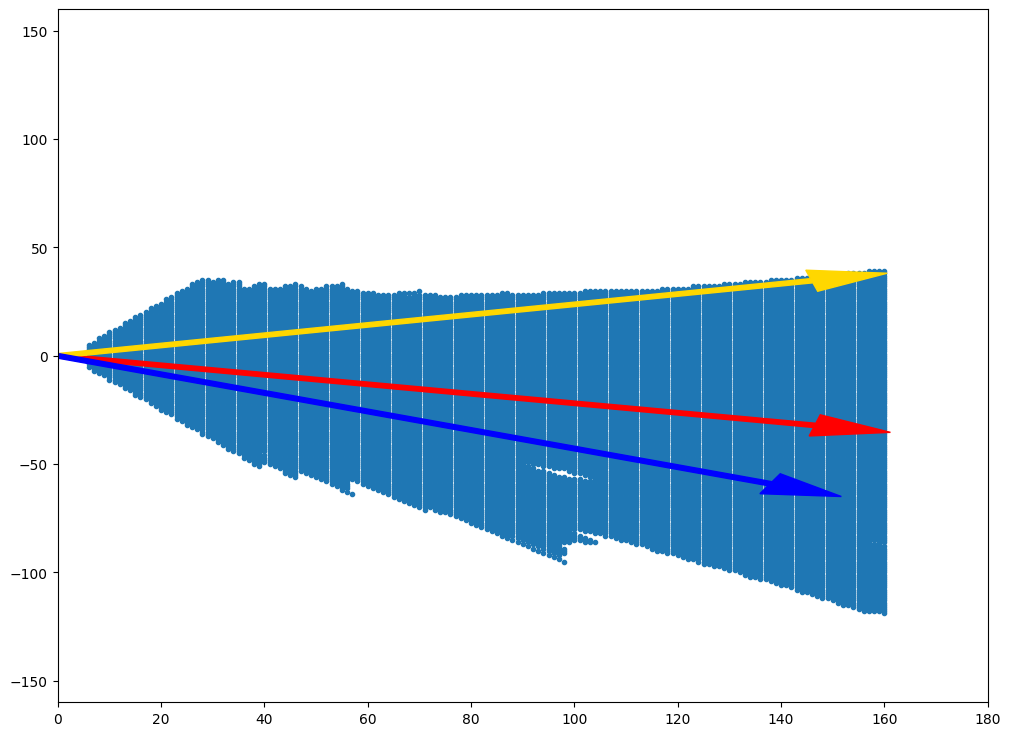

In [28]:
x_nav_test_pix, y_nav_test_pix = perspect_to_rover(threshed)
nav_test_dists, nav_test_angles = to_polar_coords(x_nav_test_pix, y_nav_test_pix)
mean_test_angle = np.mean(nav_test_angles)

# separate nav_test_angles into left and right angles
nav_test_left_angles = nav_test_angles[nav_test_angles > 0]
mean_test_left_angle = np.mean(nav_test_left_angles)

nav_test_right_angles = nav_test_angles[nav_test_angles < 0]
mean_test_right_angle = np.mean(nav_test_right_angles)

print('nav_test_angles:')
print(nav_test_angles)
print('amount: ', len(nav_test_angles))
print('mean:', mean_test_angle * 180 / np.pi)
print('')
print('nav_test_left_angles:')
print(nav_test_left_angles)
print('amount: ', len(nav_test_left_angles))
print('mean:', mean_test_left_angle * 180 / np.pi)
print('')
print('nav_test_right_angles:')
print(nav_test_right_angles)
print('amount: ', len(nav_test_right_angles))
print('mean:', mean_test_right_angle * 180 / np.pi)
print('')

#### do some plotting ######
fig = plt.figure(figsize=(12,9))
plt.plot(x_nav_test_pix, y_nav_test_pix, '.')
plt.ylim(-160, 160)
plt.xlim(0, 180)
arrow_length = 150

# main test angle
x_mean_test_angle = arrow_length * np.cos(mean_test_angle)
y_mean_test_angle = arrow_length * np.sin(mean_test_angle)
plt.arrow(0, 0, x_mean_test_angle, y_mean_test_angle, color='red', zorder=2, head_width=10, width=2)

# main left test angle
x_mean_test_left_angle = arrow_length * np.cos(mean_test_left_angle)
y_mean_test_left_angle = arrow_length * np.sin(mean_test_left_angle)
plt.arrow(0, 0, x_mean_test_left_angle, y_mean_test_left_angle, color='gold', zorder=2, head_width=10, width=2)

# main right test angle
x_mean_test_right_angle = arrow_length * np.cos(mean_test_right_angle)
y_mean_test_right_angle = arrow_length * np.sin(mean_test_right_angle)
plt.arrow(0, 0, x_mean_test_right_angle, y_mean_test_right_angle, color='blue', zorder=2, head_width=10, width=2)

#plt.savefig('nav_angles.png')

### Remove some pixels that are furthest away

In [29]:
nav_x_pixs, nav_y_pixs = perspect_to_rover(threshed)
nav_dists, nav_angles = to_polar_coords(nav_x_pixs, nav_y_pixs)

print('nav_x_pixs:')
print(nav_x_pixs)
print(nav_x_pixs.shape)
print('')
print('nav_y_pixs:')
print(nav_y_pixs)
print(nav_y_pixs.shape)
print('')
print('nav_dists:')
print('len(nav_dists):', len(nav_dists))
print(nav_dists[:4])
print('mean:', np.mean(nav_dists))
print('shape:', nav_dists.shape)
print('')

# remove some pixels that are farthest away

trim_nav_x_pixs = nav_x_pixs[nav_dists < 120]
print('trim_nav_x_pixs')
print(trim_nav_x_pixs)

trim_nav_y_pixs = nav_y_pixs[nav_dists < 120]
print('trim_nav_y_pixs')
print(trim_nav_y_pixs)


nav_x_pixs:
[160. 160. 160. ...   6.   6.   6.]
(15958,)

nav_y_pixs:
[39. 38. 37. ... -3. -4. -5.]
(15958,)

nav_dists:
len(nav_dists): 15958
[164.68454694 164.45060049 164.22241016 164.        ]
mean: 105.68993599281755
shape: (15958,)

trim_nav_x_pixs
[119. 119. 119. ...   6.   6.   6.]
trim_nav_y_pixs
[15. 14. 13. ... -3. -4. -5.]


/tmp/ipykernel_6267/1826307090.py:21: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xpix_pts_rf = -(ypix_pts_pf - height).astype(np.float)
/tmp/ipykernel_6267/1826307090.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ypix_pts_rf = -(xpix_pts_pf - width/2).astype(np.float)


## Read in saved data and ground truth map of the world
The next cell is all setup to read data saved from rover sensors into a `pandas` dataframe.  Here we'll also read in a "ground truth" map of the world, where white pixels (pixel value = 1) represent navigable terrain.  

After that, we'll define a class to store telemetry data and pathnames to images.  When the class (`data = SensorData()`) is instantiated, we'll have a global variable called `data` that can be referenced for telemetry and to map data within the `process_image()` function in the following cell.  

In [30]:
import pandas as pd  # to read in csv file as a dataframe

# Change the path below to your data directory
# If you are in a locale (e.g., Europe) that uses ',' as the decimal separator
# change the '.' to ','

# Read in csv log file as a dataframe
df = pd.read_csv('../test_dataset_2/robot_log.csv', delimiter=';', decimal='.')
csv_img_list = df["Path"].tolist()  # Create list of image pathnames

# Read in ground truth map and create a 3-channel image with it
ground_truth = mpimg.imread('../calibration_images/map_bw.png')
ground_truth_3d = np.dstack(
    (ground_truth*0,
     ground_truth*255,
     ground_truth*0)
).astype(np.float)


class SensorData():
    """
    Create a class to be a container of rover sensor data from sim.

    Reads in saved data from csv sensor log file generated by sim which
    includes saved locations of front camera snapshots and corresponding
    rover position and yaw values in world coordinate frame

    """

    def __init__(self):
        """
        Initialize a SensorData instance unique to a single simulation run.

        worldmap instance variable is instantiated with a size of 200 square
        grids corresponding to a 200 square meters space which is same size as
        the 200 square pixels ground_truth variable allowing full range
        of output position values in x and y from the sim

        """
        self.images = csv_img_list  
        self.xpos = df["X_Position"].values
        self.ypos = df["Y_Position"].values
        self.yaw = df["Yaw"].values
        self.count = 0  # This will be a running index
        self.worldmap = np.zeros((200, 200, 3)).astype(np.float)
        self.ground_truth = ground_truth_3d  # Ground truth worldmap


# Instantiate a SensorData().. this will be a global variable/object
# that can be referenced in the process_image() function below
data = SensorData()


/tmp/ipykernel_6267/2304850851.py:17: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ).astype(np.float)
/tmp/ipykernel_6267/2304850851.py:45: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.worldmap = np.zeros((200, 200, 3)).astype(np.float)


## Write a function to process stored images

The `process_image()` function below is modified by adding in the perception step processes (functions defined above) to perform image analysis and mapping.  The following cell is all set up to use this `process_image()` function in conjunction with the `moviepy` video processing package to create a video from the rover camera image data taken in the simulator.  

In short, we will be passing individual images into `process_image()` and building up an image called `output_image` that will be stored as one frame of the output video. A mosaic of the various steps of above analysis process and additional text can also be added.  

The output video ultimately demonstrates our mapping process.

In [31]:
def process_image(input_img):
    """
    Establish ROIs in rover cam image and overlay with ground truth map.

    Keyword argument:
    input_img -- 3 channel color image

    Return value:
    output_img -- 3 channel color image with ROIs identified

    Notes:
    Requires data (a global SensorData object)
    Required by the ImageSequeceClip object from moviepy module

    """
    # Example of how to use the SensorData() object defined above
    # to print the current x, y and yaw values
    # print(data.xpos[data.count], data.ypos[data.count], data.yaw[data.count])

    # 1) Define source and destination points for perspective transform
    # 2) Apply perspective transform
    warped_img = perspect_transform(input_img)

    # 3) Apply color threshold to identify following ROIs:
    #    a. navigable terrain
    #    b. obstacles
    #    c. rock samples
    thresh_img_nav, thresh_img_obs, thresh_img_rock = color_thresh(warped_img)

    # 4) Convert thresholded image pixel values to rover-centric coords
    nav_x_rover, nav_y_rover = perspect_to_rover(thresh_img_nav)
    obs_x_rover, obs_y_rover = perspect_to_rover(thresh_img_obs)
    rock_x_rover, rock_y_rover = perspect_to_rover(thresh_img_rock)

    # 5) Convert rover-centric pixel values to world coords
    my_worldmap = np.zeros((200, 200))
    my_scale = 10  # scale factor assumed between world and rover space pixels
    
    nav_x_world, nav_y_world = rover_to_world(
        nav_x_rover, nav_y_rover,
        (data.xpos[data.count], data.ypos[data.count]), data.yaw[data.count]
    )
    obs_x_world, obs_y_world = rover_to_world(
        obs_x_rover, obs_y_rover,
        (data.xpos[data.count], data.ypos[data.count]), data.yaw[data.count],
    )
    rock_x_world, rock_y_world = rover_to_world(
        rock_x_rover, rock_y_rover,
        (data.xpos[data.count], data.ypos[data.count]), data.yaw[data.count],
    )

    # 6) Update worldmap (to be displayed on right side of screen)
    data.worldmap[obs_y_world, obs_x_world, 0] += 255
    data.worldmap[rock_y_world, rock_x_world, 1] += 255
    data.worldmap[nav_y_world, nav_x_world, 2] += 255

    # 7) Make a mosaic image

    # First create a blank image (can be whatever shape)
    output_image = np.zeros(
        (input_img.shape[0] + data.worldmap.shape[0],
         input_img.shape[1]*2,
         3)
    )
    # Next you can populate regions of the image with various output
    # Here I'm putting the original image in the upper left hand corner
    output_image[0:input_img.shape[0], 0:input_img.shape[1]] = input_img

    # Let's create more images to add to the mosaic, first a warped image
    warped = perspect_transform(input_img)

    # Add the warped image in the upper right hand corner
    output_image[0:input_img.shape[0], input_img.shape[1]:] = warped

    # Overlay worldmap with ground truth map
    map_add = cv2.addWeighted(data.worldmap, 1, data.ground_truth, 0.5, 0)

    # Flip map overlay so y-axis points upward and add to output_image
    output_image[
        input_img.shape[0]:,
        0:data.worldmap.shape[1]
    ] = np.flipud(map_add)

    # Then putting some text over the image
    cv2.putText(
        output_image,
        "Testing mapping of ROI pixels into a worldmap:",
        (20, 20),
        cv2.FONT_HERSHEY_COMPLEX,
        0.4,
        (255, 255, 255),
        1
    )
    if data.count < len(data.images) - 1:
        data.count += 1  # Keep track of the index in the Databucket()

    return output_image